# Scale-Dependent Modification of Power Spectrum Multipoles

Initiate notebook.

In [1]:
from __future__ import division

from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck15

from config import use_local_package

use_local_package("../../HorizonGRound/")

from horizonground.lumfunc_modeller import (
    LFModeller,
    alpha_emitter_schechter_model,
    quasar_PLE_model,
    quasar_hybrid_model,
)
from horizonground.clustering_modification import (
    non_gaussianity_modification,
    relativistic_corrections,
    relativistic_modification,
    standard_kaiser_modification,
)

LEGEND_SETTINGS = dict(
    handlelength=1.2, 
    handletextpad=0.5,
    fontsize=16,
)

Define fiducial parameters and parameter ranges.

In [2]:
FIDUCIAL_REDSHIFT = 2.
FIDUCIAL_LINEAR_BIAS = 2.
FIDUCIAL_NON_GAUSSNIANTY = 1.

In [3]:
wavenumbers = np.logspace(-3.5, -1.5, num=200+1)
redshifts = np.linspace(0.5, 2., num=150+1)
degrees = [0, 2]

Define tracer sample.

In [4]:
SAMPLE = 'Q'  # 'H'
if SAMPLE == 'Q':
    tracer_p = 1.6
elif SAMPLE == 'H':
    tracer_p = 1

## Evolution and magnification biases

Specify luminosity function model.

In [5]:
if SAMPLE == 'Q':
    modeller = LFModeller.from_parameters_file(
        parameter_file="../data/input/PLE_model_fits.txt",
        lumfunc_model=quasar_PLE_model,
        luminosity_variable='magnitude',
        threshold_value=-21.80,
        threshold_variable='magnitude',
        cosmology=Planck15
    )
elif SAMPLE == 'H':
    modeller = LFModeller.from_parameters_file(
        parameter_file="../data/input/Schechter_model_fits.txt",
        lumfunc_model=alpha_emitter_schechter_model,
        luminosity_variable='luminosity',
        threshold_value=3.e-16,
        threshold_variable='flux',
        cosmology=Planck15
    )

evolution_bias = modeller.evolution_bias
magnification_bias = modeller.magnification_bias

Text(0,0.5,'bias')

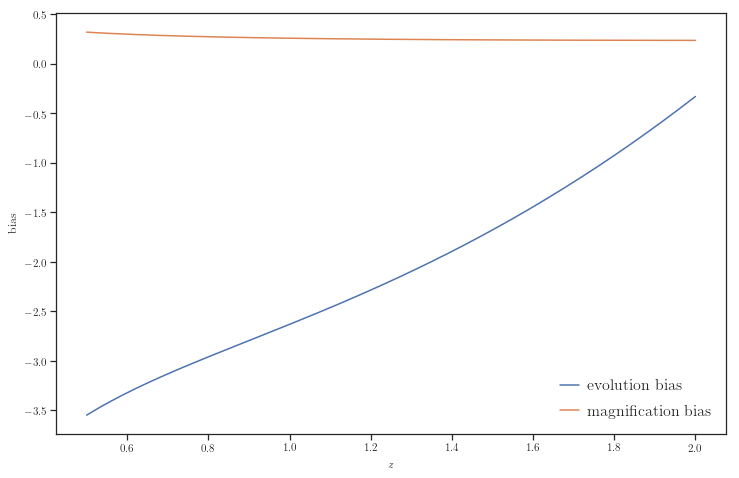

In [6]:
plt.figure(figsize=(12, 7.75))
plt.plot(redshifts, evolution_bias(redshifts), label="evolution bias")
plt.plot(redshifts, magnification_bias(redshifts), label="magnification bias")

plt.legend(**LEGEND_SETTINGS)
plt.xlabel(r"$z$")
plt.ylabel(r"bias")

## Relavitstic correction terms

Text(0,0.5,'corrections')

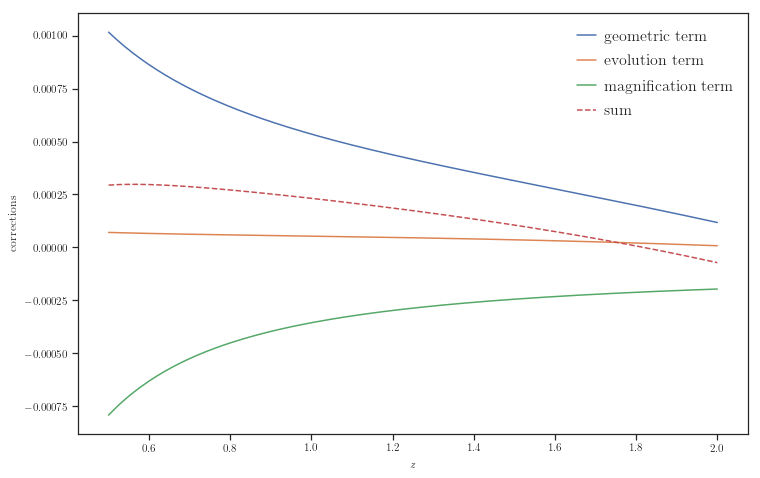

In [7]:
plt.figure(figsize=(12, 7.75))

plt.plot(
    redshifts,
    relativistic_corrections(geometric_bias=True)(redshifts),
    label="geometric term"
)
plt.plot(
    redshifts, 
    relativistic_corrections(geometric_bias=False, evolution_bias=evolution_bias)(redshifts),
    label="evolution term"
)
plt.plot(
    redshifts,
    relativistic_corrections(geometric_bias=False, magnification_bias=magnification_bias)(redshifts),
    label="magnification term"
)
plt.plot(
    redshifts,
    relativistic_corrections(evolution_bias=evolution_bias, magnification_bias=magnification_bias)(redshifts),
    ls='--', label="sum"
)

plt.legend(**LEGEND_SETTINGS)
plt.xlabel(r"$z$")
plt.ylabel(r"corrections")

## Modification results

In [8]:
kaiser_result = {
    ell: standard_kaiser_modification(
        FIDUCIAL_REDSHIFT, ell, FIDUCIAL_LINEAR_BIAS
    )
    for ell in degrees
}

In [9]:
relativistic_result = {
    ell: relativistic_modification(
        wavenumbers, FIDUCIAL_REDSHIFT, ell,
        geometric_bias=True,
        evolution_bias=evolution_bias, 
        magnification_bias=magnification_bias
    )
    for ell in degrees
}

In [10]:
non_gaussianity_result = {
    ell: non_gaussianity_modification(
        wavenumbers, FIDUCIAL_REDSHIFT, ell, 
        FIDUCIAL_NON_GAUSSNIANTY,
        FIDUCIAL_LINEAR_BIAS,
        tracer_p=tracer_p
    )
    for ell in degrees   
}

We now show the amount of modification relative to the standard Kaiser power spectrum multipoles.

Text(0,0.5,'$\\Delta P_\\ell(k) / P_\\ell^\\mathrm{K}(k)$ [$(h/\\mathrm{Mpc})^3$]')

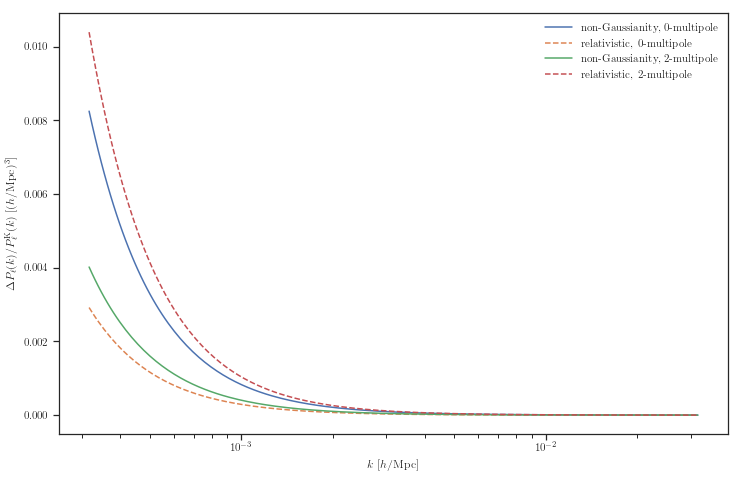

In [11]:
plt.figure(figsize=(12, 7.75))

for ell in degrees:
    plt.semilogx(
        wavenumbers, non_gaussianity_result[ell]/kaiser_result[ell],
        ls='-',
        label="non-Gaussianity, {}-multipole".format(ell)
    )
    plt.semilogx(
        wavenumbers, relativistic_result[ell]/kaiser_result[ell],
        ls='--', 
        label="relativistic, {}-multipole".format(ell)
    )

plt.legend()
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$\Delta P_\ell(k) / P_\ell^\mathrm{K}(k)$ [$(h/\mathrm{Mpc})^3$]")